In [1]:
import numpy as np

import sympy as sp
from sympy.diffgeom import Manifold, Patch, CoordSystem, metric_to_Christoffel_2nd
from sympy.diffgeom import TensorProduct as TP

from scipy.integrate import solve_ivp

# %matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Line Element

$$
ds^2 = -\left(1 - \frac{2M}{\sqrt{r^2 + b^2}}\right)dt^2 + \left(1 - \frac{2M}{\sqrt{r^2 + b^2}}\right)^{-1}dr^2 + (r^2 + b^2)(d\theta^2 + \sin^2\theta d\phi^2)
$$

By inspection we can see that $\lim_{M\to 0} ds^2$ recovers the (Ellis) Wormhole geometry, and $\lim_{b\to 0} ds^2$ recovers the Schwarzshild geometry.

# Embedding Diagram

In the limit of $b \to 0$, we recover the Schwarzchild metric w/ embedding diagram obeying

$$
z(\rho) = \sqrt{8M\rho - 16M^2}
$$

This is derived just like we derived the embedding diagram for the Wormhole geometry, i.e., note that time independence and spherical symmetry allow us to isolate the interesting geometry by considering a constant-time equitorial slice.


$$
d\Sigma^2 = \left(1 - \frac{2M}{\sqrt{r^2 + b^2}}\right)^{-1}dr^2 + \left(b^2 + r^2\right) d\phi^2
$$

Comparing to the line element for Euclidean geometry in spherical coordinates

$$
dS^2 = d\rho^2 + \rho^2 d\psi^2 + dz^2
$$

shows that

$$
\rho^2 = b^2 + r^2
$$

and

$$
\left(\frac{d\rho}{dr}\right)^2 = \left(1 - \frac{2M}{\sqrt{r^2 + b^2}}\right)^{-1} - \frac{r^2}{b^2 + r^2}
$$

Solving the above in the relavant limits result in the embedding diagrams for the Wormhole and Schwarzschild geometries.

In [2]:
def schwarz_z_over_M(ρ_over_M):
    return np.sqrt(8*ρ_over_M - 16)

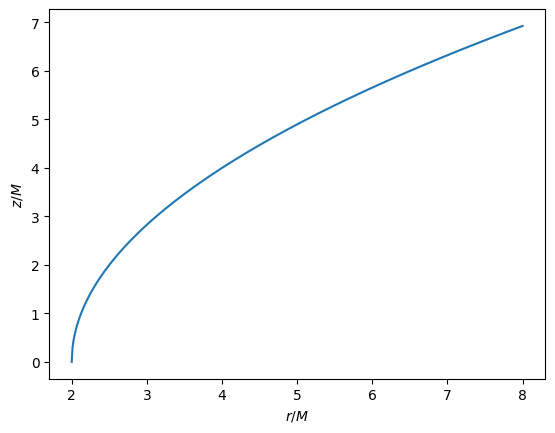

In [3]:
plt.figure()
ρ = np.linspace(2, 8, 500)
plt.plot(ρ, schwarz_z_over_M(ρ))
plt.xlabel(r'$r/M$')
plt.ylabel(r'$z/M$');

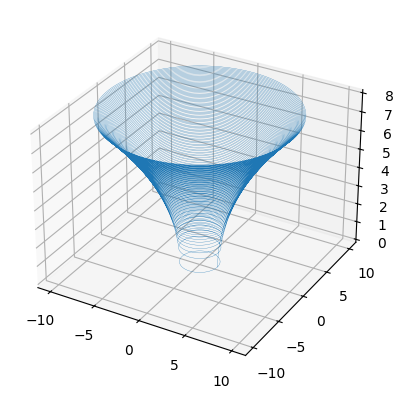

In [4]:
ngrid = 100

ϕs, ρs = np.meshgrid(np.linspace(0, 2*np.pi, ngrid), np.linspace(2, 10, ngrid))
zs = schwarz_z_over_M(ρs)

xs = (ρs*np.cos(ϕs)).flatten()
ys = (ρs*np.sin(ϕs)).flatten()
zs = zs.flatten()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot(xs, ys, zs, linewidth=0.2);

# Geodesic Motion

Let's use `sympy.diffgeom` to construct the metric.

In [5]:
# Create a manifold.
M = Manifold('M', 4)

# Create a patch.
patch = Patch('P', M)

# Constant symbols
M, b = sp.symbols('M b', positive=True, Real=True)

# Coordinate system
coord_symbols = sp.symbols('t r θ ϕ', real=True)
sph_coords = CoordSystem('spherical', patch, coord_symbols)

# Get the coordinate functions
t, r, θ, ϕ = sph_coords.coord_functions()

# Get the base one forms (differentials)
dt, dr, dθ, dϕ = sph_coords.base_oneforms()

# Auxiliar terms for the metric.
dt2 = TP(dt, dt)
dr2 = TP(dr, dr)
dθ2 = TP(dθ, dθ)
dϕ2 = TP(dϕ, dϕ)
factor = (1 - 2*M/sp.sqrt(r**2 + b**2))

# Build the metric
ds2 = -factor*dt2 + dr2/factor + (r**2 + b**2) * (dθ2 + sp.sin(θ)**2 * dϕ2)
ds2

(b**2 + r**2)*(sin(θ)**2*TensorProduct(dϕ, dϕ) + TensorProduct(dθ, dθ)) + (2*M/sqrt(b**2 + r**2) - 1)*TensorProduct(dt, dt) + TensorProduct(dr, dr)/(-2*M/sqrt(b**2 + r**2) + 1)

We can check that $b=0$ recovers the Schwarzshild geometry.

In [6]:
ds2.subs({b: 0})

(2*M/sqrt(r**2) - 1)*TensorProduct(dt, dt) + r**2*(sin(θ)**2*TensorProduct(dϕ, dϕ) + TensorProduct(dθ, dθ)) + TensorProduct(dr, dr)/(-2*M/sqrt(r**2) + 1)

Now let's calculate the Christoffel symbols for the full geometry, then create a new set of Chistoffel symbols assuming equitorial motion.

In [7]:
Γ = metric_to_Christoffel_2nd(ds2)

subs = {θ:sp.pi/2}
Γ_ = Γ.subs(subs)
Γ_

[[[0, -M*r/((2*M - sqrt(b**2 + r**2))*(b**2 + r**2)), 0, 0], [-M*r/((2*M - sqrt(b**2 + r**2))*(b**2 + r**2)), 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[M*(-2*M + sqrt(b**2 + r**2))*r/(b**2 + r**2)**2, 0, 0, 0], [0, -M*(-2*M + sqrt(b**2 + r**2))*r/((b**2 + r**2)**2*(-2*M/sqrt(b**2 + r**2) + 1)**2), 0, 0], [0, 0, -(-2*M + sqrt(b**2 + r**2))*r/sqrt(b**2 + r**2), 0], [0, 0, 0, -(-2*M + sqrt(b**2 + r**2))*r/sqrt(b**2 + r**2)]], [[0, 0, 0, 0], [0, 0, r/(b**2 + r**2), 0], [0, r/(b**2 + r**2), 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, r/(b**2 + r**2)], [0, 0, 0, 0], [0, r/(b**2 + r**2), 0, 0]]]

The effective potential for timelike orbits:

$$
V_\mathrm{eff} = \frac{\ell^2}{2} \frac{1}{r^2 + b^2} \left(1 - \frac{2M}{\sqrt{r^2 + b^2}}\right) - \frac{M}{\sqrt{r^2 + b^2}}
$$

In [8]:
ϵ, ℓ = sp.symbols('ϵ, ℓ')
ℯ = sp.sqrt(2 * ϵ + 1)
V_eff = ℓ**2/2 * 1/(r**2 + b**2) * factor - M/sp.sqrt(r**2 + b**2)

Pick some values for the constants.

In [9]:
const = {b:1, M:1, ϵ:-.01, ℓ:5, θ:sp.pi/2}
Γ_ = Γ.subs(const)

Inspect the resulting effective potential.

In [10]:
V = sp.lambdify(r, V_eff.subs(const))
V(0)

np.float64(-13.5)

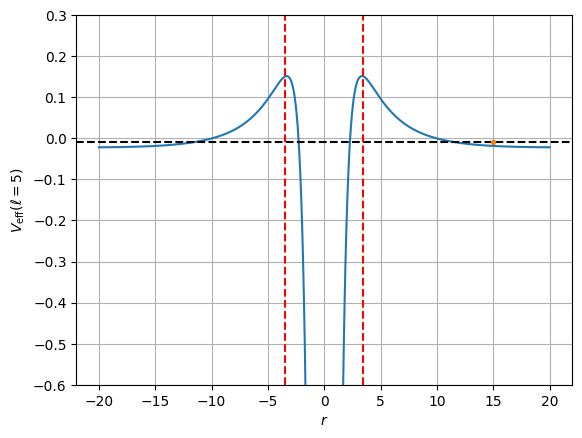

In [11]:
rs = np.linspace(-20, 20, 500)

R = 15

plt.figure()
plt.plot(rs, V(rs))
plt.axhline(const[ϵ], ls='--', color='k')
plt.ylabel(r'$V_\mathrm{{eff}}(\ell = {})$'.format(const[ℓ]));
plt.xlabel(r'$r$')
plt.ylim(-.6, .3)
plt.axvline(2*np.sqrt(4*const[M]**2-const[b]**2), ls='--', color='r')
plt.axvline(-2*np.sqrt(4*const[M]**2-const[b]**2), ls='--', color='r')

plt.plot(R, const[ϵ], marker='.')
plt.grid(True);

Define a function for making the above plot easier.

In [12]:
def plot_V_eff(const, r_range=(-20, 20), rₒ=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    rs = np.linspace(*r_range, 500)

    V = sp.lambdify(r, V_eff.subs(const))
    plt.plot(rs, V(rs))
    plt.axhline(const[ϵ], ls='--', color='k')
    plt.ylabel(r'$V_\mathrm{{eff}}(\ell = {})$'.format(const[ℓ]));
    plt.xlabel(r'$r$')
    try:
        plt.axvline(2*np.sqrt(4*const[M]**2-const[b]**2), ls='--', color='r')
        plt.axvline(-2*np.sqrt(4*const[M]**2-const[b]**2), ls='--', color='r')
    except:
        pass
    if rₒ is not None:
        plt.plot(R, const[ϵ], marker='.')
    plt.grid(True);

(-2.0, 1.0)

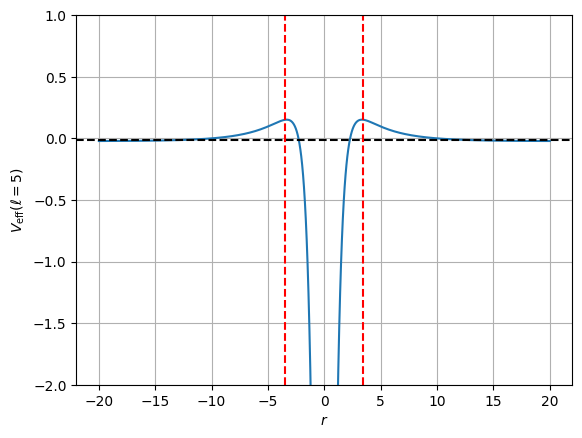

In [13]:
plot_V_eff(const)
plt.ylim(-2, 1)

Define some functions useful for numerically integrating geodesic equations.

In [14]:
def geodesic_eqn(t, y, Γ=Γ_):
    """
    Function for numerically integrating timelike geodesic equations.
    """
    x = y[0:4]
    u = y[4:8]

    dx = u
    du = [0, 0, 0, 0]
    for α in range(4):
        for β in range(4):
            for γ in range(4):
                du[α] -= Γ[α, β, γ].subs({r: x[1]}) * u[β] * u[γ]

    return np.concatenate((dx, du))

def array_subs(x, subs=None):
    """
    Perform sympy substitution for all items in an iterable.
    """
    return [sp.simplify(xᵅ).subs(subs) for xᵅ in x] if subs else x


def construct_timelike_four_velocity(ϵ, ℓ, subs=None, ur_assumptions={'real': True}):
    """
    Given constants of motion construct a timelike four velocity with unknown radial component **for this metric**
    """
    ℯ = (2*ϵ + 1)**(1/2)
    uᵗ = ℯ/factor
    uʳ = sp.symbols('ur', **ur_assumptions)
    uᶿ = 0
    uᵠ = ℓ/(r**2 + b**2)
    return array_subs([uᵗ, uʳ, uᶿ, uᵠ], subs)

def normalize_four_velocity(u, component_to_constrain=1, metric=ds2, coords=sph_coords, subs=None, timelike=True):
    """
    Given an unnormalized four-velocity and metric, normalize it by constraining the specified component.
    """
    u = array_subs(u, subs)
    if timelike:
        norm = sp.simplify('1')
    else: #assume null
        norm = sp.simplify('0')
    for α, e_α in enumerate(coords.base_vectors()):
        for β, e_β in enumerate(coords.base_vectors()):
            g_αβ = metric.rcall(e_α , e_β)
            g_αβ = g_αβ.subs(subs) if subs else g_αβ
            norm += g_αβ * u[α] * u[β]
    sol = sp.solve(norm, u[component_to_constrain])
    u[component_to_constrain] = sol[0]
    return array_subs(u, subs)

Now let's pick an initial position to evolve our orbit from.  After specifying that and the constants of motion, we have the freedom left to define the sign of the radial component of our initial four velocity.

In [15]:
xₒ = [0, R, np.pi/2, 0]

subs = const.copy()
subs.update(zip([t, r, θ, ϕ], xₒ))
uₒ = construct_timelike_four_velocity(ϵ, ℓ, subs=subs, ur_assumptions={'real':True, 'positive':False})
uₒ = normalize_four_velocity(uₒ, subs=subs)

print(subs)
F = lambda t0, x0: geodesic_eqn(t0, x0, Γ=Γ_)

{b: 1, M: 1, ϵ: -0.01, ℓ: 5, θ: 1.5707963267948966, t: 0, r: 15, ϕ: 0}


(-0.2, 0.5)

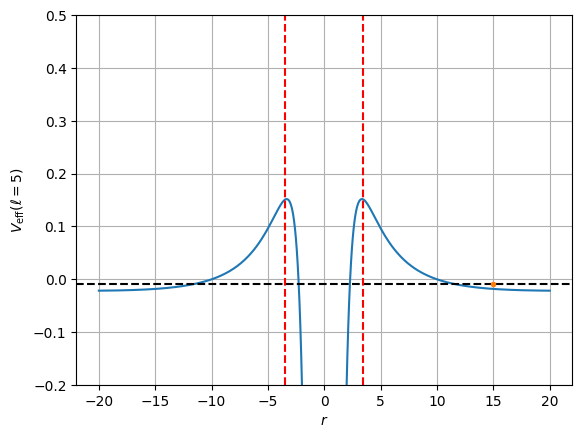

In [16]:
plot_V_eff(const, ro=R)
plt.ylim(-.2, .5)

Now we numerically integrate the geodesic equation for some interval in proper time.

In [17]:
solve_ivp?

Signature:
solve_ivp(
    fun,
    t_span,
    y0,
    method='RK45',
    t_eval=None,
    dense_output=False,
    events=None,
    vectorized=False,
    args=None,
    **options,
)
Docstring:
Solve an initial value problem for a system of ODEs.

This function numerically integrates a system of ordinary differential
equations given an initial value::

    dy / dt = f(t, y)
    y(t0) = y0

Here t is a 1-D independent variable (time), y(t) is an
N-D vector-valued function (state), and an N-D
vector-valued function f(t, y) determines the differential equations.
The goal is to find y(t) approximately satisfying the differential
equations, given an initial value y(t0)=y0.

Some of the solvers support integration in the complex domain, but note
that for stiff ODE solvers, the right-hand side must be
complex-differentiable (satisfy Cauchy-Riemann equations [11]_).
To solve a problem in the complex domain, pass y0 with a complex data type.
Another option always available is to rewrite your pro

In [18]:
T = np.linspace(0, 2000, 500)

sol = solve_ivp(geodesic_eqn, [T[0], T[-1]], xₒ+uₒ, t_eval=T)

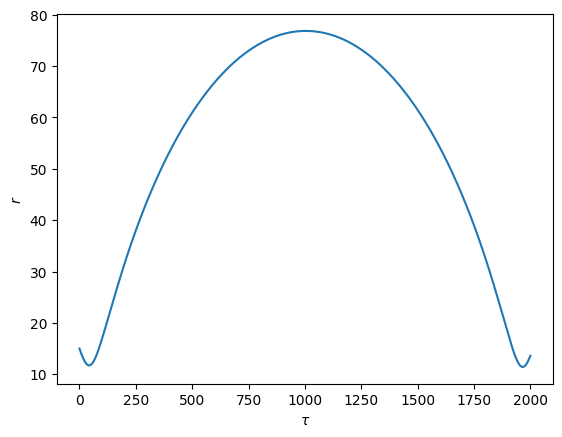

In [19]:
plt.figure()
plt.plot(sol.t, sol.y[1])
plt.xlabel(r'$\tau$')
plt.ylabel('$r$');

Let's define a function now for plotting our trajectories (in both assymptotically flat spacetimes) on separate polar plots.

In [20]:
def plot_polar_trajectory(sol, const=const):
    fig = plt.figure()

    sel = sol.y[1] > 0

    ax = fig.add_subplot(121, projection='polar')
    ax.plot(sol.y[3][sel], sol.y[1][sel])
    try:
        ax.plot(np.linspace(0, 2*np.pi, 100), 2*np.sqrt(4*const[M]**2-const[b]**2)*np.ones(100), ls='--', color='r')
    except RuntimeWarning:
        pass
    ax.grid(True)

    ax = fig.add_subplot(122, projection='polar')
    ax.plot(sol.y[3][~sel], -sol.y[1][~sel])
    ax.set_ylim(bottom=0)
    try:
        ax.plot(np.linspace(0, 2*np.pi, 100), 2*np.sqrt(4*const[M]**2-const[b]**2)*np.ones(100), ls='--', color='r')
    except RuntimeWarning:
        pass
    ax.grid(True);

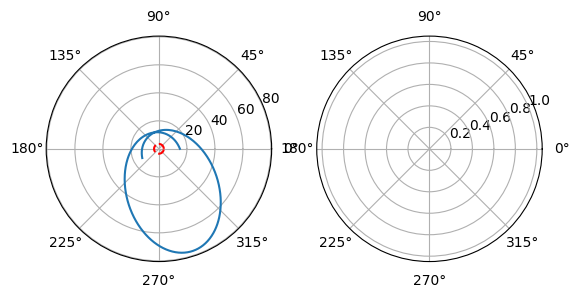

In [21]:
plot_polar_trajectory(sol)

It looks like we have a nicely bound orbit (and eccentric orbit).  If we evolve it longer we'll see some interesting evolution in its behavior.

In [22]:
T = np.linspace(0, 5000, 500)

sol = solve_ivp(geodesic_eqn, [T[0], T[-1]], xₒ+uₒ, t_eval=T)

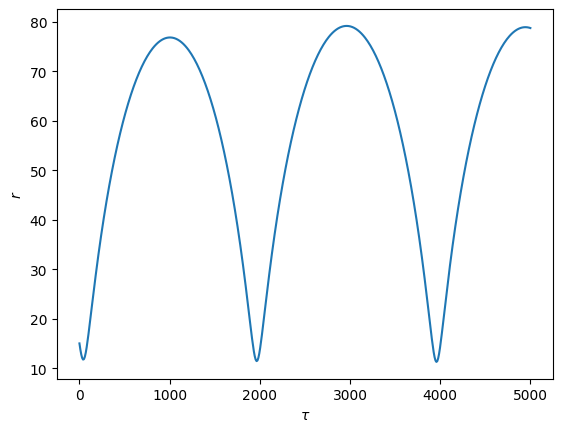

In [23]:
plt.figure()
plt.plot(sol.t, sol.y[1])
plt.xlabel(r'$\tau$')
plt.ylabel('$r$');

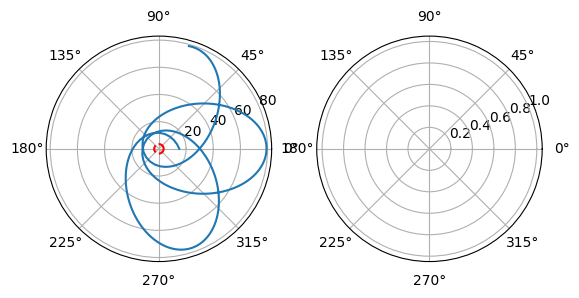

In [24]:
plot_polar_trajectory(sol)

Based on the effective potential, this is unexpected.  Since we only used the Killing vectors to define the initial conditions (the geodesic equations don't enforce the related constants of motion explicitly), we can calculate from our trajectory the instantatious "constants" at each point in our trajectory to verify that they are indeed constant.

In [25]:
def plot_constants(sol, const=const):
    fig, ax = plt.subplots()

    E = (1 - 2*const[M]/np.sqrt(sol.y[1][:-1].astype(float)**2 + float(const[b])**2))*np.diff(sol.y[0])/np.diff(sol.t)
    ax.plot(sol.t[:-1], E/E[0], color='darkblue')
    # ax.axhline(ℯ.subs(const), ls='--', color='darkblue')
    ax.set_ylabel('$e/e_0$', color='darkblue')

    ax = plt.twinx(ax)
    L = (sol.y[1][:-1]**2 + const[b]**2) * np.diff(sol.y[3])/np.diff(sol.t)
    ax.plot(sol.t[:-1], L/L[0], color='green')
    # ax.axhline(const[ℓ], ls='--', color='green')
    ax.set_ylabel('$\ell/\ell_0$', color='green')

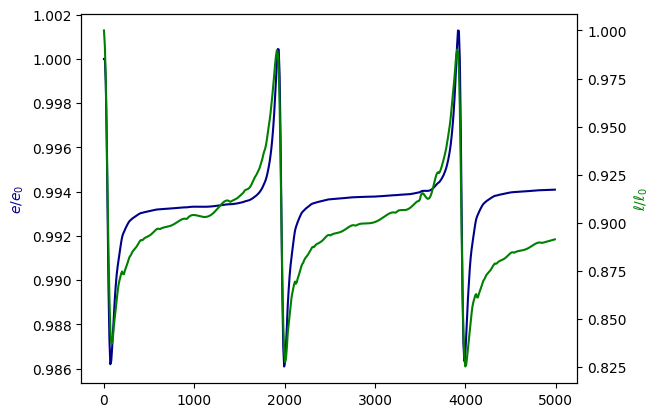

In [26]:
plot_constants(sol, const)

They appear to be far from constant, suggesting numerical error is creeping in, especially after many orbits.

Let's explore a few other geometries and initial conditions.

In [27]:
const = {b:3, M:1, ϵ:-.05, ℓ:2, θ:sp.pi/2} # bound orbit oscillating between spaces
T = np.linspace(0, 1000, 500)
R = 5

xₒ = [0, R, np.pi/2, 0]

/var/folders/b2/qcvsw_h948b_826rl483srp40000gn/T/ipykernel_23139/2123356379.py:13: RuntimeWarning: invalid value encountered in sqrt
  plt.axvline(2*np.sqrt(4*const[M]**2-const[b]**2), ls='--', color='r')
/var/folders/b2/qcvsw_h948b_826rl483srp40000gn/T/ipykernel_23139/2123356379.py:14: RuntimeWarning: invalid value encountered in sqrt
  plt.axvline(-2*np.sqrt(4*const[M]**2-const[b]**2), ls='--', color='r')


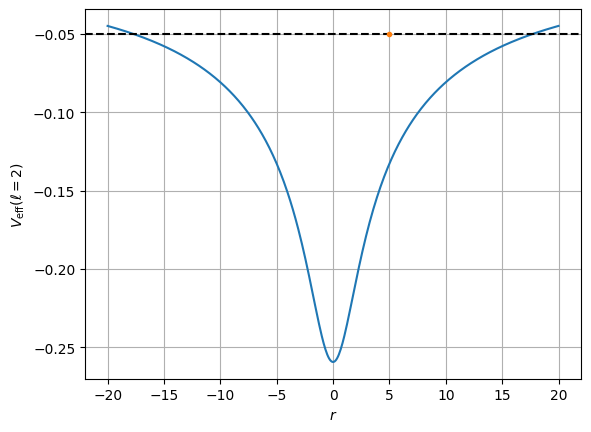

In [28]:
Γ_ = Γ.subs(const)
V = sp.lambdify(r, V_eff.subs(const))

rs = np.linspace(-20, 20, 500)
plot_V_eff(const, ro=R)

In [29]:
subs = const.copy()
subs.update(zip([t, r, θ, ϕ], xₒ))
uₒ = construct_timelike_four_velocity(ϵ, ℓ, subs=subs, ur_assumptions={'real':True, 'positive':True})
uₒ = normalize_four_velocity(uₒ, subs=subs)

print(subs)
F = lambda t0, x0: geodesic_eqn(t0, x0, Γ=Γ_)

sol = solve_ivp(F, [T[0], T[-1]], xₒ+uₒ, t_eval=T)

{b: 3, M: 1, ϵ: -0.05, ℓ: 2, θ: 1.5707963267948966, t: 0, r: 5, ϕ: 0}


/var/folders/b2/qcvsw_h948b_826rl483srp40000gn/T/ipykernel_23139/2317812926.py:9: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(np.linspace(0, 2*np.pi, 100), 2*np.sqrt(4*const[M]**2-const[b]**2)*np.ones(100), ls='--', color='r')
/var/folders/b2/qcvsw_h948b_826rl483srp40000gn/T/ipykernel_23139/2317812926.py:18: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(np.linspace(0, 2*np.pi, 100), 2*np.sqrt(4*const[M]**2-const[b]**2)*np.ones(100), ls='--', color='r')


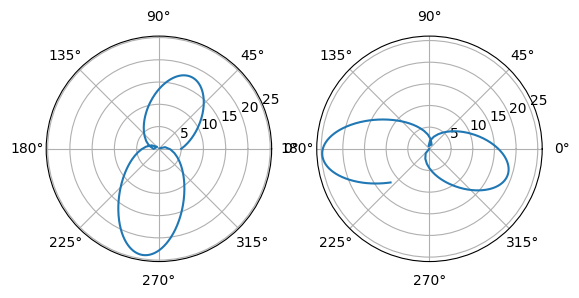

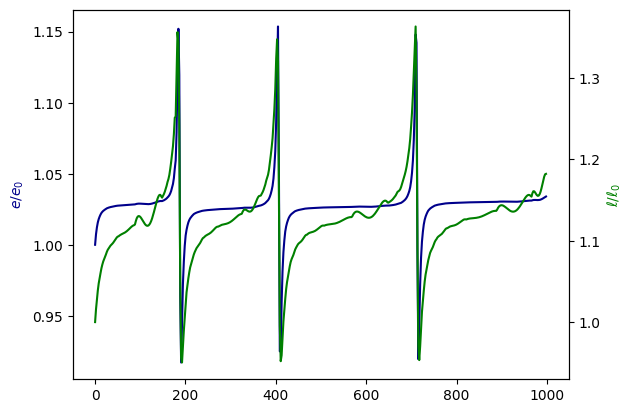

In [30]:
plot_polar_trajectory(sol, const)
plot_constants(sol, const)

In [31]:
const = {b:2.5, M:1, ϵ:.15, ℓ:5, θ:sp.pi/2}
T = np.linspace(0, 500, 5000)
R = .5
xₒ = [0, R, np.pi/2, 0]

/var/folders/b2/qcvsw_h948b_826rl483srp40000gn/T/ipykernel_23139/2123356379.py:13: RuntimeWarning: invalid value encountered in sqrt
  plt.axvline(2*np.sqrt(4*const[M]**2-const[b]**2), ls='--', color='r')
/var/folders/b2/qcvsw_h948b_826rl483srp40000gn/T/ipykernel_23139/2123356379.py:14: RuntimeWarning: invalid value encountered in sqrt
  plt.axvline(-2*np.sqrt(4*const[M]**2-const[b]**2), ls='--', color='r')


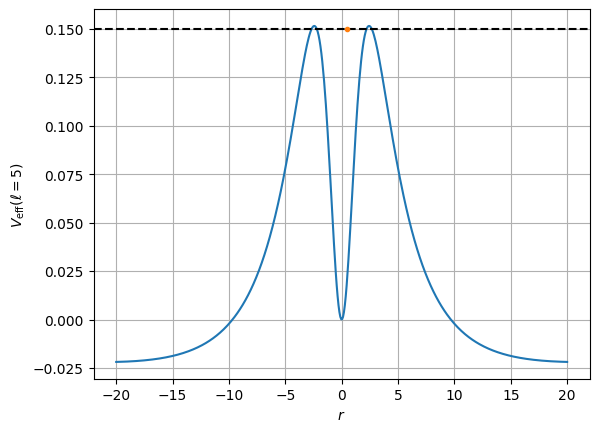

In [32]:
Γ_ = Γ.subs(const)
V = sp.lambdify(r, V_eff.subs(const))

rs = np.linspace(-20, 20, 500)
plot_V_eff(const, ro=R)

In [33]:
subs = const.copy()
subs.update(zip([t, r, θ, ϕ], xₒ))
uₒ = construct_timelike_four_velocity(ϵ, ℓ, subs=subs, ur_assumptions={'real':True, 'positive':True})
uₒ = normalize_four_velocity(uₒ, subs=subs)

print(subs)
F = lambda t0, x0: geodesic_eqn(t0, x0, Γ=Γ_)

sol = solve_ivp(F, [T[0], T[-1]], xₒ+uₒ, t_eval=T)

{b: 2.5, M: 1, ϵ: 0.15, ℓ: 5, θ: 1.5707963267948966, t: 0, r: 0.5, ϕ: 0}


/var/folders/b2/qcvsw_h948b_826rl483srp40000gn/T/ipykernel_23139/2317812926.py:9: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(np.linspace(0, 2*np.pi, 100), 2*np.sqrt(4*const[M]**2-const[b]**2)*np.ones(100), ls='--', color='r')
/var/folders/b2/qcvsw_h948b_826rl483srp40000gn/T/ipykernel_23139/2317812926.py:18: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(np.linspace(0, 2*np.pi, 100), 2*np.sqrt(4*const[M]**2-const[b]**2)*np.ones(100), ls='--', color='r')


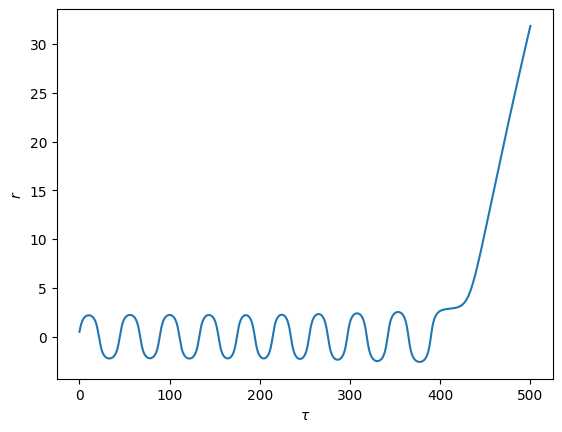

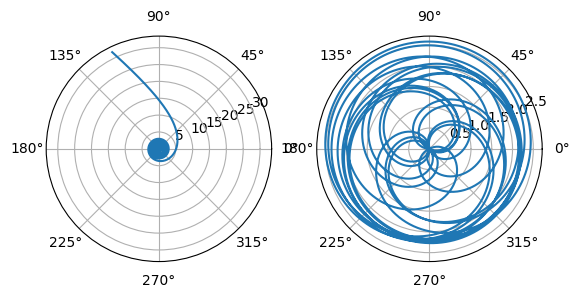

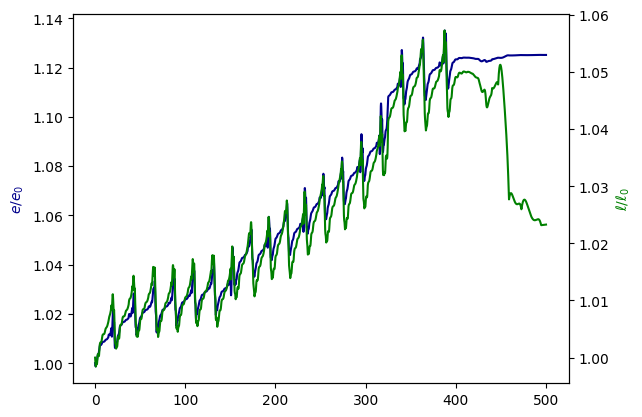

In [34]:
plt.figure()
plt.plot(sol.t, sol.y[1])
plt.xlabel(r'$\tau$')
plt.ylabel('$r$');

plot_polar_trajectory(sol, const)
plot_constants(sol, const)